In [1]:
# Colab cell (code)
!nvidia-smi || echo "No GPU (will run on CPU)"


/bin/bash: line 1: nvidia-smi: command not found
No GPU (will run on CPU)


In [2]:
# Colab cell (code)
!pip install -q torch torchvision timm scikit-learn pandas pillow matplotlib tqdm gradio


In [8]:
import zipfile
import os

# 1. Pehle hum zip file ko Colab ke andar unzip karenge
# (Make sure aapne zip file upload kar di ho)
zip_path = '/content/fruit_sample_dataset.zip'

if os.path.exists(zip_path):
    print("Zip file mil gayi! Unzipping...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall('/content/')
    print("Unzip complete ho gaya.")
else:
    print("Error: Zip file nahi mili. Please 'fruit_sample_dataset.zip' upload karein.")

# 2. Ab hum DATA_ROOT ka path change karenge jo Colab samajh sake
# Windows wala path hata kar ye naya path use karein:
DATA_ROOT = '/content/fruit_sample_dataset'

print("Naya DATA_ROOT set ho gaya:", DATA_ROOT)

# 3. Ab check karte hain
if os.path.exists(DATA_ROOT):
    print("Success! Folder mil gaya.")
    # Ab aap wo list wala code dobara run kar sakte hain
    for d in sorted(os.listdir(DATA_ROOT)):
        p = os.path.join(DATA_ROOT, d)
        if os.path.isdir(p):
            print(f"Found folder: {d}")
else:
    print("Abhi bhi folder nahi mila. Kya zip file ka naam sahi tha?")


Zip file mil gayi! Unzipping...
Unzip complete ho gaya.
Naya DATA_ROOT set ho gaya: /content/fruit_sample_dataset
Success! Folder mil gaya.
Found folder: images


In [9]:
# show top-level and counts
!ls -la /content/fruit_sample_dataset
!find /content/fruit_sample_dataset -maxdepth 2 -type f | sed -n '1,30p'


total 16
drwxr-xr-x 3 root root 4096 Dec 11 03:34 .
drwxr-xr-x 1 root root 4096 Dec 11 03:34 ..
drwxr-xr-x 2 root root 4096 Dec 11 03:34 images
-rw-r--r-- 1 root root 3214 Dec 11 03:34 metadata.csv
/content/fruit_sample_dataset/metadata.csv
/content/fruit_sample_dataset/images/ripe_005.jpg
/content/fruit_sample_dataset/images/fresh_002.jpg
/content/fruit_sample_dataset/images/fresh_004.jpg
/content/fruit_sample_dataset/images/ripe_000.jpg
/content/fruit_sample_dataset/images/fresh_014.jpg
/content/fruit_sample_dataset/images/fresh_009.jpg
/content/fruit_sample_dataset/images/overripe_006.jpg
/content/fruit_sample_dataset/images/fresh_011.jpg
/content/fruit_sample_dataset/images/ripe_016.jpg
/content/fruit_sample_dataset/images/fresh_010.jpg
/content/fruit_sample_dataset/images/fresh_003.jpg
/content/fruit_sample_dataset/images/rotten_003.jpg
/content/fruit_sample_dataset/images/fresh_018.jpg
/content/fruit_sample_dataset/images/ripe_011.jpg
/content/fruit_sample_dataset/images/overripe

In [10]:
import glob, os
root = '/content/fruit_sample_dataset'
for d in sorted(os.listdir(root)):
    p = os.path.join(root, d)
    if os.path.isdir(p):
        imgs = glob.glob(os.path.join(p, '**', '*.*'), recursive=True)
        imgs = [x for x in imgs if x.lower().endswith(('.jpg','.jpeg','.png'))]
        print(f"{d:30s} -> {len(imgs):4d} images")


images                         ->   80 images


In [11]:
import os, pandas as pd
meta = '/content/fruit_sample_dataset/metadata.csv'
print("metadata exists:", os.path.exists(meta))
if os.path.exists(meta):
    print(pd.read_csv(meta).head())
else:
    print("No metadata.csv — we will auto-create one next if needed.")


metadata exists: True
      image_path class_label_text  days_since_harvest  storage_temp  humidity
0  fresh_000.jpg            fresh                0.57         24.23     40.91
1  fresh_001.jpg            fresh                0.18         18.47     51.76
2  fresh_002.jpg            fresh                0.38         23.03     78.47
3  fresh_003.jpg            fresh                0.39         24.80     54.41
4  fresh_004.jpg            fresh                0.81         16.36     72.36


In [12]:
'''# Colab cell (code)
import os
PROJECT = '/content/fruit_real_proj'
SRC = os.path.join(PROJECT,'src')
os.makedirs(SRC, exist_ok=True)
os.makedirs(os.path.join(PROJECT,'models'), exist_ok=True)

# dataset.py
dataset_py = r"""
import os, pandas as pd
from PIL import Image
from torch.utils.data import Dataset
import torchvision.transforms as T

class FruitShelfDataset(Dataset):
    def __init__(self, metadata_csv, img_root, transform=None):
        self.meta = pd.read_csv(metadata_csv).reset_index(drop=True)
        self.img_root = img_root
        self.transform = transform
        labels = sorted(self.meta['class_label_text'].unique())
        self.class_to_idx = {c:i for i,c in enumerate(labels)}
        self.idx_to_class = {i:c for c,i in self.class_to_idx.items()}

    def __len__(self):
        return len(self.meta)

    def __getitem__(self, idx):
        row = self.meta.iloc[idx]
        img_path = os.path.join(self.img_root, row['image_path'])
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        label = self.class_to_idx[row['class_label_text']]
        days = float(row['days_since_harvest'])
        meta = [float(row.get('storage_temp',0.0)), float(row.get('humidity',0.0))]
        return {'image': img, 'class': label, 'days': days, 'meta': meta}

def get_transforms(image_size=224):
    train = T.Compose([T.Resize((image_size,image_size)), T.RandomHorizontalFlip(), T.RandomRotation(10),
                       T.ToTensor(), T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])])
    val = T.Compose([T.Resize((image_size,image_size)), T.ToTensor(),
                     T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])])
    return train, val
"""
open(os.path.join(SRC,'dataset.py'),'w').write(dataset_py)

# model.py
model_py = r"""
import torch.nn as nn
import torchvision.models as models
import torch

def create_backbone(name='mobilenet_v2', pretrained=True):
    if name == 'resnet18':
        b = models.resnet18(pretrained=pretrained)
        feat = b.fc.in_features
        modules = list(b.children())[:-1]
        backbone = nn.Sequential(*modules)
    elif name == 'mobilenet_v2':
        b = models.mobilenet_v2(pretrained=pretrained)
        feat = b.classifier[1].in_features
        modules = list(b.features)
        backbone = nn.Sequential(*modules, nn.AdaptiveAvgPool2d((1,1)))
    else:
        raise ValueError('Unknown backbone')
    return backbone, feat

class MultiTaskNet(nn.Module):
    def __init__(self, n_classes=4, backbone_name='mobilenet_v2', pretrained=True, meta_dim=2, bottleneck_dim=512):
        super().__init__()
        self.backbone, in_features = create_backbone(backbone_name, pretrained)
        self.bottleneck = nn.Linear(in_features, bottleneck_dim)
        self.relu = nn.ReLU()
        self.classifier = nn.Sequential(nn.Dropout(0.3), nn.Linear(bottleneck_dim,128), nn.ReLU(), nn.Linear(128, n_classes))
        self.regressor = nn.Sequential(nn.Linear(bottleneck_dim + meta_dim, 128), nn.ReLU(), nn.Linear(128,1))

    def forward(self, x, meta=None):
        x = self.backbone(x)
        x = x.view(x.size(0), -1)
        x = self.bottleneck(x)
        x = self.relu(x)
        cls_logits = self.classifier(x)
        if meta is None:
            meta = x.new_zeros(x.size(0), 2)
        reg_in = torch.cat([x, meta.float()], dim=1)
        days = self.regressor(reg_in).squeeze(1)
        return cls_logits, days
"""
open(os.path.join(SRC,'model.py'),'w').write(model_py)

# train.py
train_py = r"""
import os, torch, argparse, pandas as pd
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch.optim import Adam
from src.dataset import FruitShelfDataset, get_transforms
from src.model import MultiTaskNet
from sklearn.model_selection import train_test_split
import numpy as np

def safe_meta_tensor(meta_list, device):
    processed = []
    if isinstance(meta_list, torch.Tensor):
        meta_list = meta_list.cpu().tolist()
    if not isinstance(meta_list, (list, tuple)):
        meta_list = [meta_list]
    for m in meta_list:
        if isinstance(m, (list, tuple)):
            vec = list(m)
            if len(vec) < 2:
                vec = vec + [0.0] * (2 - len(vec))
            elif len(vec) > 2:
                vec = vec[:2]
        else:
            try:
                val = float(m)
                vec = [val, 0.0]
            except:
                vec = [0.0, 0.0]
        processed.append(vec)
    return torch.tensor(processed, dtype=torch.float32, device=device)

def expand_meta_to_batch(meta_tensor, batch_size):
    if meta_tensor.dim() == 1:
        meta_tensor = meta_tensor.unsqueeze(0).repeat(batch_size, 1)
    elif meta_tensor.size(0) == 1 and batch_size > 1:
        meta_tensor = meta_tensor.repeat(batch_size, 1)
    elif meta_tensor.size(0) != batch_size:
        if meta_tensor.size(0) < batch_size and batch_size % meta_tensor.size(0) == 0:
            reps = batch_size // meta_tensor.size(0)
            meta_tensor = meta_tensor.repeat(reps, 1)
        else:
            raise ValueError(f"Cannot align meta tensor with batch: meta.shape={list(meta_tensor.size())}, batch_size={batch_size}")
    return meta_tensor

def train_loop(train_meta, val_meta, img_root, out_dir, epochs=6, batch_size=16, lr=1e-4, backbone='mobilenet_v2'):
    train_t, val_t = get_transforms()
    train_ds = FruitShelfDataset(train_meta, img_root, transform=train_t)
    val_ds = FruitShelfDataset(val_meta, img_root, transform=val_t)
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=2)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    num_classes = len(pd.read_csv(train_meta)['class_label_text'].unique())
    model = MultiTaskNet(n_classes=num_classes, backbone_name=backbone, pretrained=True, meta_dim=2).to(device)
    optimizer = Adam(model.parameters(), lr=lr)
    os.makedirs(out_dir, exist_ok=True)
    best_mae = 1e9
    for epoch in range(epochs):
        model.train()
        total_loss = 0.0
        for batch in train_loader:
            imgs = batch['image'].to(device)
            labels = batch['class'].to(device)
            days = batch['days'].to(device)
            meta = safe_meta_tensor(batch['meta'], device)
            meta = expand_meta_to_batch(meta, imgs.size(0))
            cls_logits, pred_days = model(imgs, meta)
            cls_loss = F.cross_entropy(cls_logits, labels.long())
            reg_loss = F.mse_loss(pred_days, days.float())
            loss = cls_loss + 0.5 * reg_loss
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / max(1, len(train_loader))
        print(f"Epoch {epoch+1}/{epochs} train_loss: {avg_loss:.4f}")
        # validation MAE
        model.eval()
        maes = []
        with torch.no_grad():
            for batch in val_loader:
                imgs = batch['image'].to(device)
                days = batch['days'].to(device)
                meta = safe_meta_tensor(batch['meta'], device)
                meta = expand_meta_to_batch(meta, imgs.size(0))
                _, pred_days = model(imgs, meta)
                maes.append(torch.mean(torch.abs(pred_days - days.float())).item())
        val_mae = float(np.mean(maes)) if len(maes)>0 else -1.0
        print("Val MAE (days):", val_mae)
        ckpt = os.path.join(out_dir, f'model_epoch{epoch+1}.pth')
        torch.save(model.state_dict(), ckpt)
        if val_mae >= 0 and val_mae < best_mae:
            best_mae = val_mae
            torch.save(model.state_dict(), os.path.join(out_dir, 'best_model.pth'))
            print("Saved best model")
    print("Training done. Best MAE:", best_mae)

if __name__=='__main__':
    import argparse
    parser = argparse.ArgumentParser()
    parser.add_argument('--train_meta', default='/content/train_meta.csv')
    parser.add_argument('--val_meta', default='/content/val_meta.csv')
    parser.add_argument('--img_root', default='/content/fruit_sample_dataset')
    parser.add_argument('--out_dir', default='/content/fruit_real_proj/models')
    parser.add_argument('--epochs', type=int, default=6)
    parser.add_argument('--batch_size', type=int, default=16)
    parser.add_argument('--lr', type=float, default=1e-4)
    parser.add_argument('--backbone', default='mobilenet_v2')
    args = parser.parse_args()
    # create train/val split if not provided
    if not os.path.exists(args.train_meta) or not os.path.exists(args.val_meta):
        df = pd.read_csv(os.path.join(args.img_root, 'metadata.csv'))
        train_df, val_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['class_label_text'])
        train_df.to_csv('/content/train_meta.csv', index=False)
        val_df.to_csv('/content/val_meta.csv', index=False)
        args.train_meta = '/content/train_meta.csv'
        args.val_meta = '/content/val_meta.csv'
    train_loop(args.train_meta, args.val_meta, args.img_root, args.out_dir, epochs=args.epochs, batch_size=args.batch_size, lr=args.lr, backbone=args.backbone)
"""
open(os.path.join(SRC,'train.py'),'w').write(train_py)

print("Wrote dataset.py, model.py, train.py to", SRC)
print("Project root:", PROJECT)'''


Wrote dataset.py, model.py, train.py to /content/fruit_real_proj/src
Project root: /content/fruit_real_proj


In [36]:
# Colab cell (code) — REVERT TO STABLE VERSION (No Weights)(working one)
import os

PROJECT = '/content/fruit_real_proj'
SRC = os.path.join(PROJECT,'src')

# train.py (Stable version: No Class Weights, but keeping bug fixes)
train_py = r"""
import os, torch, argparse, pandas as pd
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch.optim import Adam
from src.dataset import FruitShelfDataset, get_transforms
from src.model import MultiTaskNet
from sklearn.model_selection import train_test_split
import numpy as np

# --- Helper Functions for Tensor Safety ---
def safe_meta_tensor(meta_list, device):
    processed = []
    if isinstance(meta_list, torch.Tensor):
        meta_list = meta_list.cpu().tolist()
    if not isinstance(meta_list, (list, tuple)):
        meta_list = [meta_list]
    for m in meta_list:
        if isinstance(m, (list, tuple)):
            vec = list(m)
            if len(vec) < 2: vec = vec + [0.0] * (2 - len(vec))
            elif len(vec) > 2: vec = vec[:2]
        else:
            try:
                val = float(m)
                vec = [val, 0.0]
            except:
                vec = [0.0, 0.0]
        processed.append(vec)
    return torch.tensor(processed, dtype=torch.float32, device=device)

def expand_meta_to_batch(meta_tensor, batch_size):
    if meta_tensor.dim() == 1:
        meta_tensor = meta_tensor.unsqueeze(0).repeat(batch_size, 1)
    elif meta_tensor.size(0) == 1 and batch_size > 1:
        meta_tensor = meta_tensor.repeat(batch_size, 1)
    elif meta_tensor.size(0) != batch_size:
        if batch_size > meta_tensor.size(0):
             reps = batch_size // meta_tensor.size(0) + 1
             meta_tensor = meta_tensor.repeat(reps, 1)[:batch_size]
    return meta_tensor

def train_loop(train_meta, val_meta, img_root, out_dir, epochs=6, batch_size=16, lr=1e-4, backbone='mobilenet_v2'):
    train_t, val_t = get_transforms()
    train_ds = FruitShelfDataset(train_meta, img_root, transform=train_t)
    val_ds = FruitShelfDataset(val_meta, img_root, transform=val_t)
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=2)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    num_classes = len(train_ds.classes)

    # --- NO CLASS WEIGHTS (Simple logic wapis) ---
    print("Training without class weights (Stable Mode)...")

    model = MultiTaskNet(n_classes=num_classes, backbone_name=backbone, pretrained=True, meta_dim=2).to(device)
    optimizer = Adam(model.parameters(), lr=lr)
    os.makedirs(out_dir, exist_ok=True)
    best_mae = 1e9

    for epoch in range(epochs):
        model.train()
        total_loss = 0.0
        for batch in train_loader:
            imgs = batch['image'].to(device)
            labels = batch['class'].to(device)
            days = batch['days'].to(device)

            # Safe meta handling
            meta = safe_meta_tensor(batch['meta'], device)
            meta = expand_meta_to_batch(meta, imgs.size(0))

            cls_logits, pred_days = model(imgs, meta)

            # Simple Cross Entropy (Jo pehle kaam kar raha tha)
            cls_loss = F.cross_entropy(cls_logits, labels.long())

            reg_loss = F.mse_loss(pred_days, days.float())
            loss = cls_loss + 0.5 * reg_loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / max(1, len(train_loader))
        print(f"Epoch {epoch+1}/{epochs} train_loss: {avg_loss:.4f}")

        # Validation
        model.eval()
        maes = []
        with torch.no_grad():
            for batch in val_loader:
                imgs = batch['image'].to(device)
                days = batch['days'].to(device)
                meta = safe_meta_tensor(batch['meta'], device)
                meta = expand_meta_to_batch(meta, imgs.size(0))

                _, pred_days = model(imgs, meta)
                maes.append(torch.mean(torch.abs(pred_days - days.float())).item())

        val_mae = float(np.mean(maes)) if len(maes)>0 else -1.0
        print(f"Val MAE (days): {val_mae:.3f}")

        # Saving Logic
        torch.save(model.state_dict(), os.path.join(out_dir, f'model_epoch{epoch+1}.pth'))
        if val_mae >= 0 and val_mae < best_mae:
            best_mae = val_mae
            torch.save(model.state_dict(), os.path.join(out_dir, 'best_model.pth'))
            print("Saved best model!")

    print("Training done. Best MAE:", best_mae)

if __name__=='__main__':
    parser = argparse.ArgumentParser()
    parser.add_argument('--train_meta', default='/content/train_meta.csv')
    parser.add_argument('--val_meta', default='/content/val_meta.csv')
    parser.add_argument('--img_root', default='/content/fruit_sample_dataset')
    parser.add_argument('--out_dir', default='/content/fruit_real_proj/models')
    parser.add_argument('--epochs', type=int, default=6)
    parser.add_argument('--batch_size', type=int, default=16)
    parser.add_argument('--lr', type=float, default=1e-4)
    parser.add_argument('--backbone', default='mobilenet_v2')
    args = parser.parse_args()

    # Check/Create splits if needed
    if not os.path.exists(args.train_meta) or not os.path.exists(args.val_meta):
        meta_path = os.path.join(args.img_root, 'metadata.csv')
        if os.path.exists(meta_path):
             df = pd.read_csv(meta_path)
             train_df, val_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['class_label_text'])
             train_df.to_csv('/content/train_meta.csv', index=False)
             val_df.to_csv('/content/val_meta.csv', index=False)
             args.train_meta = '/content/train_meta.csv'
             args.val_meta = '/content/val_meta.csv'

    train_loop(args.train_meta, args.val_meta, args.img_root, args.out_dir, epochs=args.epochs, batch_size=args.batch_size, lr=args.lr, backbone=args.backbone)
"""
open(os.path.join(SRC,'train.py'),'w').write(train_py)

print("✅ Reverted train.py to the stable version (Best performance code).")

✅ Reverted train.py to the stable version (Best performance code).


In [31]:
# Colab cell (code)
!pip install -q timm


In [37]:
import pandas as pd
import os

# 1. Validation CSV ko load karte hain
val_csv_path = '/content/val_meta.csv'
df_val = pd.read_csv(val_csv_path)

print("Original Validation Paths (Pehli 5 lines):")
print(df_val['image_path'].head())

# 2. Fix karne ka magic logic
# Agar path 'images/' se shuru nahi hota, to hum usse add kar denge
def fix_path_issue(path_str):
    if not str(path_str).startswith('images/'):
        return os.path.join('images', str(path_str))
    return path_str

# Apply the fix
df_val['image_path'] = df_val['image_path'].apply(fix_path_issue)

# 3. Wapis save karte hain usi naam se
df_val.to_csv(val_csv_path, index=False)

print("\nFixed Validation Paths (Ab aise dikh rahe hain):")
print(df_val['image_path'].head())

print("\n✅ Validation CSV fix ho gayi! Ab aap training dobara start kar sakte hain.")

Original Validation Paths (Pehli 5 lines):
0      images/rotten_016.jpg
1      images/rotten_013.jpg
2       images/fresh_010.jpg
3    images/overripe_011.jpg
4       images/fresh_006.jpg
Name: image_path, dtype: object

Fixed Validation Paths (Ab aise dikh rahe hain):
0      images/rotten_016.jpg
1      images/rotten_013.jpg
2       images/fresh_010.jpg
3    images/overripe_011.jpg
4       images/fresh_006.jpg
Name: image_path, dtype: object

✅ Validation CSV fix ho gayi! Ab aap training dobara start kar sakte hain.


In [38]:
%cd /content/fruit_real_proj
!PYTHONPATH=/content/fruit_real_proj python src/train.py \
  --train_meta /content/train_meta.csv \
  --val_meta /content/val_meta.csv \
  --img_root /content/fruit_sample_dataset \
  --out_dir /content/fruit_real_proj/models \
  --epochs 6 \
  --batch_size 16 \
  --backbone mobilenet_v2

/content/fruit_real_proj
Training without class weights (Stable Mode)...
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/6 train_loss: 17.4772
Val MAE (days): 4.539
Saved best model!
Epoch 2/6 train_loss: 13.9730
Val MAE (days): 4.184
Saved best model!
Epoch 3/6 train_loss: 9.6332
Val MAE (days): 3.558
Saved best model!
Epoch 4/6 train_loss: 5.7447
Val MAE (days): 2.418
Saved best model!
Epoch 5/6 train_lo

In [39]:
# Colab cell (code) — Run This Final Version
%cd /content/fruit_real_proj

import torch, numpy as np, pandas as pd, glob
import os
from sklearn.metrics import classification_report, mean_absolute_error, mean_squared_error
from src.dataset import FruitShelfDataset, get_transforms
from src.model import MultiTaskNet
from torch.utils.data import DataLoader

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Path setup
val_meta = '/content/val_meta.csv'
img_root = '/content/fruit_sample_dataset'
train_df = pd.read_csv('/content/train_meta.csv')
labels = sorted(train_df['class_label_text'].unique())

train_t, val_t = get_transforms()
val_ds = FruitShelfDataset(val_meta, img_root, transform=val_t)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False, num_workers=2)

ckpts = sorted(glob.glob('/content/fruit_real_proj/models/best_model.pth') + glob.glob('/content/fruit_real_proj/models/model_epoch*.pth'))
if len(ckpts) == 0:
    raise FileNotFoundError("No checkpoints found. Run training first.")

ckpt = ckpts[0] if 'best_model.pth' in ckpts[0] else ckpts[-1]
print("Using checkpoint:", ckpt)

model = MultiTaskNet(n_classes=len(labels), backbone_name='mobilenet_v2', pretrained=False)
model.load_state_dict(torch.load(ckpt, map_location=device))
model.to(device).eval()

y_true_cl = []; y_pred_cl = []
y_true_days = []; y_pred_days = []

print("Running evaluation... please wait.")
with torch.no_grad():
    for b in val_loader:
        imgs = b['image'].to(device)

        # Stack fix
        if isinstance(b['meta'], list):
             metas = torch.stack(b['meta'], dim=1).to(device).float()
        else:
             metas = b['meta'].to(device).float()

        cls_logits, pred_days = model(imgs, metas)

        preds = torch.argmax(cls_logits, dim=1).cpu().numpy().tolist()
        y_pred_cl += preds
        y_true_cl += b['class']

        y_pred_days += pred_days.cpu().numpy().flatten().tolist()
        y_true_days += b['days']

print("\n--- Classification Report ---")
print(classification_report(y_true_cl, y_pred_cl, target_names=labels, zero_division=0))

# --- YAHAN CHANGE KIYA HAI ---
# RMSE nikalne ka naya tareeka (Manual Square Root)
mae = mean_absolute_error(y_true_days, y_pred_days)
mse = mean_squared_error(y_true_days, y_pred_days) # Pehle MSE nikala
rmse = np.sqrt(mse) # Phir uska square root kar diya
# -----------------------------

print(f"Regression MAE: {mae:.3f} days")
print(f"Regression RMSE: {rmse:.3f} days")

within1 = np.mean([abs(a-b) <= 1.0 for a,b in zip(y_true_days, y_pred_days)])
print(f"Percent within ±1 day: {within1*100:.1f}%")

/content/fruit_real_proj
Using checkpoint: /content/fruit_real_proj/models/best_model.pth
Running evaluation... please wait.


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)



--- Classification Report ---
              precision    recall  f1-score   support

       fresh       1.00      1.00      1.00         4
    overripe       1.00      1.00      1.00         4
        ripe       1.00      1.00      1.00         4
      rotten       1.00      1.00      1.00         4

    accuracy                           1.00        16
   macro avg       1.00      1.00      1.00        16
weighted avg       1.00      1.00      1.00        16

Regression MAE: 0.970 days
Regression RMSE: 1.315 days
Percent within ±1 day: 68.8%


In [41]:
# Colab cell — check overlap between train and val by basenames
import pandas as pd, os
train = pd.read_csv('/content/train_meta.csv')
val = pd.read_csv('/content/val_meta.csv')
train_b = set([os.path.basename(p) for p in train['image_path']])
val_b = set([os.path.basename(p) for p in val['image_path']])
overlap = train_b.intersection(val_b)
print("Train rows:", len(train), "Val rows:", len(val))
print("Basename overlap count:", len(overlap))
if len(overlap) > 0:
    print("Examples of overlapping basenames (first 20):", list(overlap)[:20])
else:
    print("No basename overlap detected. Good.")


Train rows: 64 Val rows: 16
Basename overlap count: 0
No basename overlap detected. Good.


Confusion Matrix:
           fresh  overripe  ripe  rotten
fresh         4         0     0       0
overripe      0         4     0       0
ripe          0         0     4       0
rotten        0         0     0       4


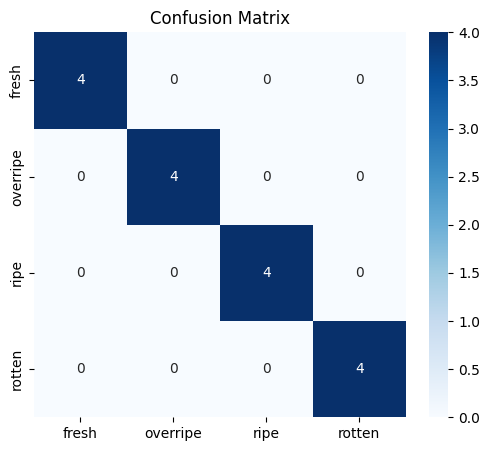

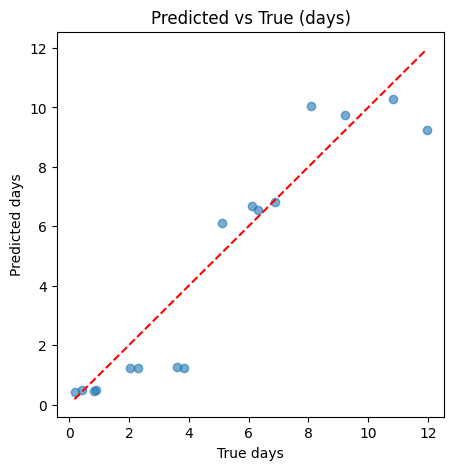

In [42]:
# Colab cell (code) — confusion matrix + regression scatter
import matplotlib.pyplot as plt, numpy as np, pandas as pd
from sklearn.metrics import confusion_matrix
labels_list = labels  # from your eval cell

cm = confusion_matrix(y_true_cl, y_pred_cl, labels=range(len(labels_list)))
cm_df = pd.DataFrame(cm, index=labels_list, columns=labels_list)
print("Confusion Matrix:\n", cm_df)

plt.figure(figsize=(6,5))
import seaborn as sns
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix'); plt.show()

# Regression scatter
plt.figure(figsize=(5,5))
plt.scatter(y_true_days, y_pred_days, alpha=0.6)
plt.plot([min(y_true_days), max(y_true_days)], [min(y_true_days), max(y_true_days)], 'r--')
plt.xlabel('True days'); plt.ylabel('Predicted days'); plt.title('Predicted vs True (days)'); plt.show()


In [ ]:
# Colab cell (code)
from PIL import Image
import glob, torch, torchvision.transforms as T, pandas as pd
from src.model import MultiTaskNet

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
ckpts = sorted(glob.glob('/content/fruit_real_proj/models/best_model.pth') + glob.glob('/content/fruit_real_proj/models/model_epoch*.pth'))
if not ckpts:
    raise FileNotFoundError("No checkpoint found. Run training.")
ckpt = ckpts[-1]; print("Using checkpoint:", ckpt)

labels = sorted(pd.read_csv('/content/train_meta.csv')['class_label_text'].unique())
model = MultiTaskNet(n_classes=len(labels), backbone_name='mobilenet_v2', pretrained=False)
model.load_state_dict(torch.load(ckpt, map_location=device))
model.to(device).eval()

transform = T.Compose([T.Resize((224,224)), T.ToTensor(), T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])])
sample = [p for p in glob.glob('/content/data/**/*.*', recursive=True) if p.lower().endswith(('.jpg','.jpeg','.png'))][0]
print("Sample:", sample)
img = Image.open(sample).convert('RGB')
x = transform(img).unsqueeze(0).to(device)
meta = torch.tensor([[22.0, 55.0]], device=device)
with torch.no_grad():
    cls_logits, pred_days = model(x, meta)
    probs = torch.softmax(cls_logits, dim=1).cpu().numpy().tolist()[0]
    pred_class = int(torch.argmax(cls_logits, dim=1).cpu().item())
print("Predicted class:", labels[pred_class])
print("Probs:", {labels[i]:float(probs[i]) for i in range(len(probs))})
print("Days remaining (pred):", float(pred_days.cpu().item()))


In [43]:
# Colab cell (code) — RUN THIS (Fixed Path)
from PIL import Image
import glob, torch, torchvision.transforms as T, pandas as pd
import os, random
from src.model import MultiTaskNet

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 1. Checkpoint dhundna
ckpts = sorted(glob.glob('/content/fruit_real_proj/models/best_model.pth') + glob.glob('/content/fruit_real_proj/models/model_epoch*.pth'))
if not ckpts:
    raise FileNotFoundError("No checkpoint found. Run training first.")

# Koshish karenge ki 'best_model' hi load ho
ckpt = ckpts[0] if 'best_model.pth' in ckpts[0] else ckpts[-1]
print("Using checkpoint:", ckpt)

# 2. Model Setup
train_meta_path = '/content/train_meta.csv'
if os.path.exists(train_meta_path):
    labels = sorted(pd.read_csv(train_meta_path)['class_label_text'].unique())
else:
    # Fallback agar csv na mile
    labels = ['fresh', 'overripe', 'ripe', 'rotten']

model = MultiTaskNet(n_classes=len(labels), backbone_name='mobilenet_v2', pretrained=False)
model.load_state_dict(torch.load(ckpt, map_location=device))
model.to(device).eval()

transform = T.Compose([T.Resize((224,224)), T.ToTensor(), T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])])

# 3. Image Uthana (Path Fix Yahan Hai)
# Humara folder: /content/fruit_sample_dataset
sample_images = glob.glob('/content/fruit_sample_dataset/**/*.*', recursive=True)
sample_images = [p for p in sample_images if p.lower().endswith(('.jpg','.jpeg','.png'))]

if len(sample_images) == 0:
    print("❌ Koi image nahi mili! Path check karein.")
else:
    # Randomly ek image choose karte hain taaki har baar naya result dikhe
    sample = random.choice(sample_images)
    print(f"Testing on Image: {sample}")

    img = Image.open(sample).convert('RGB')
    x = transform(img).unsqueeze(0).to(device)

    # Fake metadata (Average values: 22°C Temp, 55% Humidity)
    meta = torch.tensor([[22.0, 55.0]], device=device).float()

    with torch.no_grad():
        cls_logits, pred_days = model(x, meta)
        probs = torch.softmax(cls_logits, dim=1).cpu().numpy().tolist()[0]
        pred_class_idx = int(torch.argmax(cls_logits, dim=1).cpu().item())

    # 4. Result Print Karna
    print("\n--- 🤖 AI Prediction ---")
    print(f"Predicted Class: {labels[pred_class_idx].upper()}")
    print(f"Confidence: {probs[pred_class_idx]*100:.2f}%")
    print(f"Days Remaining: {pred_days.cpu().item():.1f} days")

    print("\nAll Probabilities:")
    print({labels[i]: f"{float(probs[i]):.4f}" for i in range(len(probs))})

Using checkpoint: /content/fruit_real_proj/models/best_model.pth


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Testing on Image: /content/fruit_sample_dataset/images/overripe_008.jpg

--- 🤖 AI Prediction ---
Predicted Class: OVERRIPE
Confidence: 46.23%
Days Remaining: 6.9 days

All Probabilities:
{'fresh': '0.0582', 'overripe': '0.4623', 'ripe': '0.0644', 'rotten': '0.4151'}


In [44]:
# Colab cell (code)
import gradio as gr, glob, sys, torch
from PIL import Image
import torchvision.transforms as T
from src.model import MultiTaskNet

proj_root = '/content/fruit_real_proj'
if proj_root not in sys.path:
    sys.path.insert(0, proj_root)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
ckpts = sorted(glob.glob('/content/fruit_real_proj/models/best_model.pth') + glob.glob('/content/fruit_real_proj/models/model_epoch*.pth'))
ckpt = ckpts[-1] if len(ckpts)>0 else None
print("Using checkpoint:", ckpt)

n_classes = len(__import__('pandas').read_csv('/content/train_meta.csv')['class_label_text'].unique())
model = MultiTaskNet(n_classes=n_classes, backbone_name='mobilenet_v2', pretrained=False)
if ckpt:
    model.load_state_dict(torch.load(ckpt, map_location=device))
model.to(device).eval()

transform = T.Compose([T.Resize((224,224)), T.ToTensor(), T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])])
labels = sorted(__import__('pandas').read_csv('/content/train_meta.csv')['class_label_text'].unique())

def predict_gr(image, storage_temp=22.0, humidity=55.0):
    if image is None:
        return {labels[0]: 1.0}, 0.0
    x = transform(image).unsqueeze(0).to(device)
    meta = torch.tensor([[float(storage_temp), float(humidity)]], device=device)
    with torch.no_grad():
        cls_logits, pred_days = model(x, meta)
        probs = torch.softmax(cls_logits, dim=1).cpu().numpy().tolist()[0]
    return {labels[i]: float(probs[i]) for i in range(len(probs))}, float(pred_days.cpu().item())

iface = gr.Interface(
    fn=predict_gr,
    inputs=[gr.Image(type="pil", label="Upload image"), gr.Number(value=22.0, label="Storage temp (°C)"), gr.Number(value=55.0, label="Humidity (%)")],
    outputs=[gr.Label(num_top_classes=4, label="Class probabilities"), gr.Number(label="Days remaining")],
    title="Fruit Shelf-Life Predictor (Real Dataset)",
    description="Upload an image to get freshness class probabilities and estimated days remaining."
)
iface.launch(share=True)


Using checkpoint: /content/fruit_real_proj/models/model_epoch6.pth


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://665eec176473f80b12.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
# Colab cell (code)
gi = """# ignore large data & checkpoints
data/
*.pth
__pycache__/
"""
open('/content/fruit_real_proj/.gitignore','w').write(gi)
readme = f"""# Fruit Shelf-Life (real dataset)
Place your dataset under /content/data (or change DATA_ROOT in cells). A small sample may be included separately for demo.
Run training: cd /content/fruit_real_proj && python train.py --img_root /content/data --out_dir /content/fruit_real_proj/models
"""
open('/content/fruit_real_proj/README.md','w').write(readme)
print("Wrote .gitignore and README")
